In [1]:
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt, Tsit5, PIDController
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
#plt.style.use('ggplot')


import jax
import numpy as np
#jax.config.update("jax_enable_x64", True)
import jax.random as jrandom

import time
from functools import partial

cd = jnp.array([0.4, 0.02])
c, d = 0.4, 0.02

def lvfunc(t, y, args):
    u, v = y
    a, b = jax.nn.sigmoid(args)
    du = a * u - b * u * v
    dv = -c * v + d * u * v
    nugget = 1e-6
    return jnp.array([du, dv]) + nugget

#true_param_vals = jnp.array([-2, -4]) + 0.0
true_param_vals = jnp.array([-1, -3]) + 0.0

#x_init = jnp.ones((2,)) * 10.0
x_init = jnp.array([10.0, 15.0])

tmax = 80.0
tobs = 60.0

ts = jnp.linspace(0.0, tobs, 100)

stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)
term = ODETerm(lvfunc)
solver = Dopri5()
saveat = SaveAt(ts=ts)

p = jax.nn.sigmoid(true_param_vals)
ratio = p[1]/p[0]
true_params = jnp.array([true_param_vals[0], jax.scipy.special.logit(ratio)])

solution = diffeqsolve(term, solver, t0=0, t1=tmax, dt0=0.05, y0=x_init, saveat=SaveAt(dense=True), args=true_param_vals, stepsize_controller=stepsize_controller)

In [2]:
solution

Solution(
  t0=f32[],
  t1=f32[],
  ts=None,
  ys=None,
  interpolation=DenseInterpolation(
    ts=f32[4097],
    ts_size=weak_i32[],
    infos={'k': f32[4096,7,2], 'y0': f32[4096,2], 'y1': f32[4096,2]},
    interpolation_cls=diffrax._solver.dopri5._Dopri5Interpolation,
    direction=weak_i32[],
    t0_if_trivial=f32[],
    y0_if_trivial=f32[2]
  ),
  stats={
    'max_steps': 4096,
    'num_accepted_steps': weak_i32[],
    'num_rejected_steps': weak_i32[],
    'num_steps': weak_i32[]
  },
  result=EnumerationItem(_value=i32[], _enumeration=diffrax._solution.RESULTS),
  solver_state=None,
  controller_state=None,
  made_jump=None,
  event_mask=None
)

In [3]:
from diffrax import ControlTerm, Euler, MultiTerm, VirtualBrownianTree, ReversibleHeun, SEA, HalfSolver, ItoMilstein
key = jrandom.PRNGKey(14) # 15

rng, key = jrandom.split(key)
diff_coef = jnp.diag(jnp.array([0.2, 0.2]))
diffusion = lambda t, y, args: diff_coef

brownian_motion = VirtualBrownianTree(t0=0, t1=tmax, tol=1e-3, shape=(2,), key=rng)
terms = MultiTerm(ODETerm(lvfunc), ControlTerm(diffusion, brownian_motion))
solver = ItoMilstein()#HalfSolver(SEA()) #Euler()
saveat = SaveAt(dense=True)

stepsize_controller = PIDController(pcoeff=0.1, icoeff=0.3, rtol=1e-3, atol=1e-3)

sol = diffeqsolve(terms, solver, t0=0, t1=tmax, dt0=0.1, y0=x_init, saveat=saveat, args=true_param_vals)

In [4]:
noise_sigma = 1.0
ts = jnp.linspace(0, tobs, 120)[1:]

obs_1 = jax.vmap(solution.evaluate)(ts)
obs_2 = jax.vmap(sol.evaluate)(ts)

rng, key = jrandom.split(key)
obs_1 += noise_sigma * jrandom.normal(rng, obs_1.shape)
rng, key = jrandom.split(key)
obs_2 += noise_sigma * jrandom.normal(rng, obs_2.shape)

In [13]:
obs_2.shape

(119, 2)

In [5]:
lotka_volterra = {
    "Well specified": {
        "X_fin": None,
        "KGD_values": None
    },
    "MFLD": {
        "X_fin": None,
        "KGD_values": None
    },

    "Extensible Sampling": {
        "X_fin": None,
        "KGD_values": None},

    "Variational Gradient Descent": {
        "X_fin": None,
        "KGD_values": None
    }
}

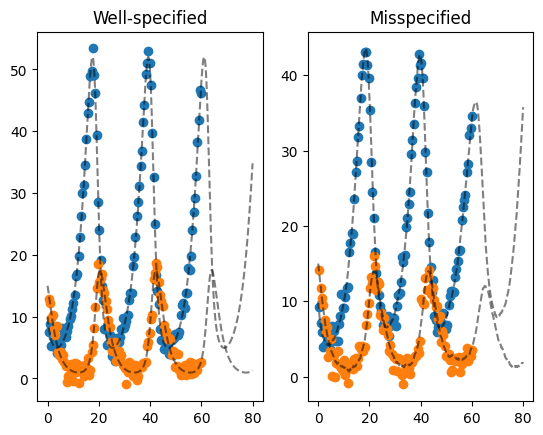

In [6]:
# plot L-V misspecified
# Note: some misspecified solution can be numerically unstable - you might need to choose a random seed that produces trajectories like below


plt.subplot(1, 2, 1)
plt.title("Well-specified")
plt.scatter(ts, obs_1[:, 0])
plt.scatter(ts, obs_1[:, 1])
t1 = jnp.linspace(0, tmax, 1000)
tj = jax.vmap(solution.evaluate)(t1)
plt.plot(t1, tj[:, 0], c='k', linestyle='--', alpha=0.5)
plt.plot(t1, tj[:, 1], c='k', linestyle='--', alpha=0.5)

plt.subplot(1, 2, 2)
plt.title("Misspecified")
plt.scatter(ts, obs_2[:, 0])
plt.scatter(ts, obs_2[:, 1])

tj = jax.vmap(sol.evaluate)(t1)
plt.plot(t1, tj[:, 0], c='k', linestyle='--', alpha=0.5)
plt.plot(t1, tj[:, 1], c='k', linestyle='--', alpha=0.5)

In [7]:
def build_lotka_volterra(y0, ts, params):
    # use parameters to simulate trajectories
    def lvfunc(t, y, args):
        u, v = y
        
        a = jax.nn.sigmoid(args[0])
        b = a * jax.nn.sigmoid(args[1])
        
        du = a * u - b * u * v
        dv = -c * v + d * u * v
        nugget = 1e-10
        return jnp.array([du, dv]) + nugget
        
    term = ODETerm(lvfunc)
    solver = Tsit5()
    saveat = SaveAt(ts=ts)
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)
    return diffeqsolve(term, solver, t0=ts[0], t1=ts[-1], dt0=0.05, y0=y0, saveat=saveat, args=params, stepsize_controller=stepsize_controller).ys

In [8]:
# kernel follows a normal density function
ls2 = 1.0
kernel = lambda x, mu, s2: jnp.exp(jnp.sum(-0.5 * jnp.log(2*jnp.pi*s2) - 0.5 * jnp.square(x-mu)/s2 + 0.5 * jnp.log(2*jnp.pi*ls2)))

# default lengthscale value

def build_first_variation(y0, ts, obs, gamma):
    # this function returns the first variation given the observations (ts, obs), the initial state y0
    def particle_updates_marginalized(params_set, params_set2=None):
        # this function takes a set of particles (params_set) as input, and outputs the first variation of L(Q)
        # the gradient of this function is the drift term for mean-field Langevin diffusion
        n_particles = params_set.shape[0]
        if params_set2 is None:
            params_set2 = params_set.copy()
        params_set2 = jax.lax.stop_gradient(params_set2)
        trajs1 = jax.vmap(build_lotka_volterra, (None, None, 0))(y0, ts, params_set)
        trajs2 = jax.vmap(build_lotka_volterra, (None, None, 0))(y0, ts, params_set2)
            
        s2 = jnp.square(noise_sigma)
            
        def calculate_V(tj):
            kxy = jax.vmap(kernel, (0, 0, None))(obs, tj, s2 + ls2)
            return jnp.sum(kxy)
                
        def calculate_W(tj1, tj2):
            kxy = jax.vmap(kernel, (0, 0, None))(tj2, tj1, 2 * s2 + ls2)
            return jnp.sum(kxy)
                
        Vs = jax.vmap(calculate_V)(trajs1)
        Ws = jax.vmap(jax.vmap(calculate_W, (None, 0)), (0, None))(trajs1, trajs2)
        Ws = jnp.sum(Ws, 1) / n_particles
            
        return jnp.sum(Vs - Ws) * gamma
        
    return particle_updates_marginalized

In [9]:
import jax
from jax import jit 

#gradL in the wellspecified case
drift_func_ws = lambda gamma : jax.value_and_grad(jax.jit(build_first_variation(x_init, ts, obs_2,gamma)), 0)
gradL_ws = jit(lambda X,gamma : -drift_func_ws(gamma)(X)[1])

#gradL in the misspecified case
drift_func_ms = lambda gamma : jax.value_and_grad(jax.jit(build_first_variation(x_init, ts, obs_2,gamma)), 0)
gradL_ms = jit(lambda X,gamma : -drift_func_ms(gamma)(X)[1])

In [10]:
build_lotka_volterra(x_init, ts, true_param_vals)

Array([[10.       , 15.       ],
       [10.447493 , 13.590515 ],
       [11.007387 , 12.376171 ],
       [11.681415 , 11.340619 ],
       [12.472831 , 10.468805 ],
       [13.386131 ,  9.74749  ],
       [14.426786 ,  9.16553  ],
       [15.599964 ,  8.714925 ],
       [16.910366 ,  8.390951 ],
       [18.361662 ,  8.192383 ],
       [19.955042 ,  8.122143 ],
       [21.687067 ,  8.188676 ],
       [23.547861 ,  8.406892 ],
       [25.518631 ,  8.799455 ],
       [27.56702  ,  9.399086 ],
       [29.641699 , 10.251068 ],
       [31.66783  , 11.414848 ],
       [33.539967 , 12.9645405],
       [35.11916  , 14.984399 ],
       [36.234665 , 17.559208 ],
       [36.700428 , 20.74394  ],
       [36.347565 , 24.523438 ],
       [35.078457 , 28.756294 ],
       [32.921646 , 33.139595 ],
       [30.059427 , 37.22858  ],
       [26.793531 , 40.538788 ],
       [23.463993 , 42.68722  ],
       [20.352362 , 43.50438  ],
       [17.634201 , 43.04949  ],
       [15.378524 , 41.542225 ],
       [13

In [11]:
trajs1 = jax.vmap(build_lotka_volterra, (None, None, 0))(x_init, ts, true_param_vals[None, :])


In [12]:
trajs1

Array([[[10.       , 15.       ],
        [10.447493 , 13.590515 ],
        [11.007387 , 12.376171 ],
        [11.681415 , 11.340619 ],
        [12.472831 , 10.468805 ],
        [13.386131 ,  9.74749  ],
        [14.426786 ,  9.16553  ],
        [15.599964 ,  8.714925 ],
        [16.910366 ,  8.390951 ],
        [18.361662 ,  8.192383 ],
        [19.955042 ,  8.122143 ],
        [21.687067 ,  8.188676 ],
        [23.547861 ,  8.406892 ],
        [25.518631 ,  8.799455 ],
        [27.56702  ,  9.399086 ],
        [29.641699 , 10.251068 ],
        [31.66783  , 11.414848 ],
        [33.539967 , 12.9645405],
        [35.11916  , 14.984399 ],
        [36.234665 , 17.559208 ],
        [36.700428 , 20.74394  ],
        [36.347565 , 24.523438 ],
        [35.078457 , 28.756294 ],
        [32.921646 , 33.139595 ],
        [30.059427 , 37.22858  ],
        [26.793531 , 40.538788 ],
        [23.463993 , 42.68722  ],
        [20.352362 , 43.50438  ],
        [17.634201 , 43.04949  ],
        [15.37